# 理解全幅切片图像：

这是第一次实践课程，将指导您学习如何可视化和操作千兆像素的全幅切片图像（WSIs）。

## Qupath  

![](https://github.com/guillaumejaume/mil-tutorial/blob/main/support/wsi_example.png?raw=true)

我们将使用QuPath，这是一个开源软件，允许可视化、注释边界框，并从全幅切片图像（WSIs）中提取信息。

构建计算病理学流程时，您通常需要：

- 评估图像质量：确保染色质量良好，图像没有模糊或墨迹。
- 验证注释的质量，无论是在幻灯片级别还是区域（框或密集像素注释）。
- 理解在图像学习中需要考虑的任务类型或先验知识，例如：
   - 如果是分类不同的肿瘤亚型，需要知道肿瘤占幻灯片的百分比。
   - 如果是检测小物体，如有丝分裂，需要知道适当的分辨率。
- 验证深度学习系统在细粒度注释上的质量。

QuPath是执行所有这些任务的最佳工具！

操作指南：

- 下载QuPath（[https://qupath.readthedocs.io/en/0.4/docs/intro/installation.html#download-install](https://qupath.readthedocs.io/en/0.4/docs/intro/installation.html#download-install)）
   - 支持Windows、Mac和Ubuntu
   - 需要4GB的RAM（在大多数现代计算机上能够顺畅运行）

从这里下载全幅切片图像：

- [https://drive.google.com/file/d/1GWtuOLRf6-7C8zCG6b3JdYDPk_C5IS3_/view?usp=sharing](https://drive.google.com/file/d/1GWtuOLRf6-7C8zCG6b3JdYDPk_C5IS3_/view?usp=sharing)
- [https://drive.google.com/file/d/1o9Es1qdY15y8q_gsjX3KVkn7HS8amlSF/view?usp=sharing](https://drive.google.com/file/d/1o9Es1qdY15y8q_gsjX3KVkn7HS8amlSF/view?usp=sharing)

使用QuPath探索这两个全幅切片图像（WSIs）：
- 一张带有坏死区域的大鼠肝脏尸检图像
- 一张侵袭性乳腺癌（BRCA）的TCGA样本图像

## OpenSlide

QuPath 对于快速探索新数据集、制作小型注释等非常有用，但它不能用于健壳的深度学习流程中。相反，我们可以使用 OpenSlide，这是一个开源的 Python 包，可以打开、读取和保存 WSI（通常是幻灯片的一小部分）。

OpenSlide 是一个非常小的包，具有相当简洁的 API（参见 https://openslide.org/api/python/）。它还支持大多数金字塔格式，如 tiff、svs、ndpi、mrxs 等。这些格式通常取决于用于数字化幻灯片的扫描仪。

In [112]:
# Install openslide 
!pip install openslide-python

### Accessing slide properties and reading

In [114]:
# 理解幻灯片属性 

import os
import pandas as pd
from glob import glob
from openslide import OpenSlide
from pprint import pprint
import matplotlib.pyplot as plt

slide_path = os.path.join('data', 'slides', 'necrosis.tiff')
slide = OpenSlide(slide_path)

# 检查最高分辨率（20x）下的图像尺寸： 
print('图像尺寸为：', slide.dimensions[0], ' x ', slide.dimensions[1])

# 检查预提取级别的数量：
print('级别数量：', slide.level_count)

# 检查每个级别的尺寸：
print('所有级别：')
for dims in slide.level_dimensions:
    print('    - (', dims[0], ' x ', dims[1], ')')

# 检查幻灯片大小 
print(f"文件大小：{round(os.path.getsize(slide_path) / 1024 ** 2, 2)} MB")

# 可选：检查所有幻灯片属性 
# pprint(dict(slide.properties))

Image size is:  61751  x  35769
Number of levels:  3
All levels:
    - ( 61751  x  35769 )
    - ( 15437  x  8942 )
    - ( 3859  x  2235 )
file size: 671.22 MB


![](https://github.com/guillaumejaume/mil-tutorial/blob/main/support/context_resolution.png?raw=true)

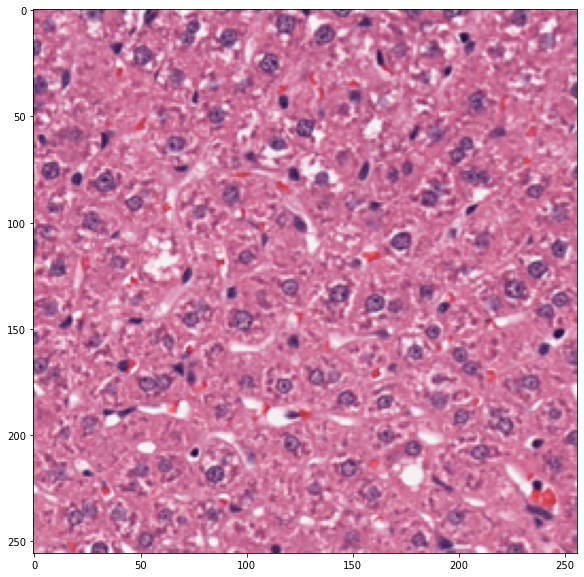

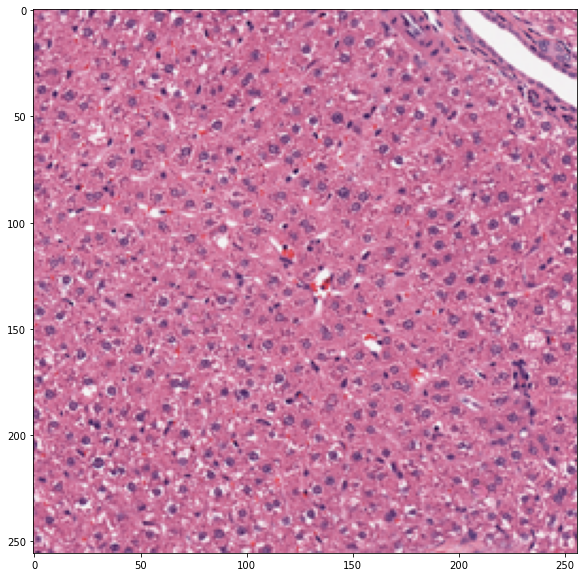

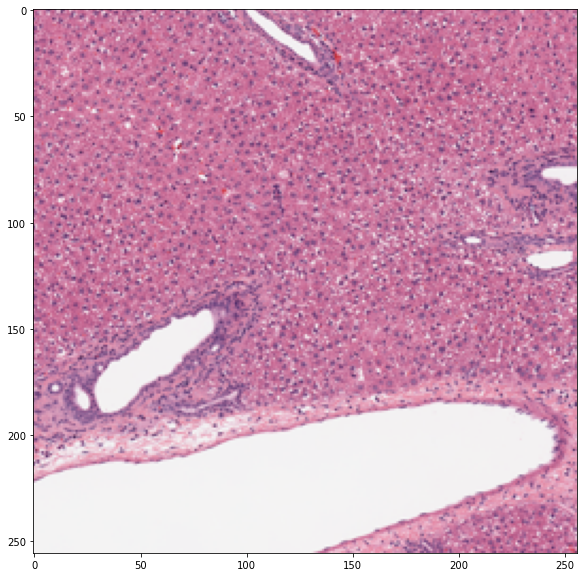

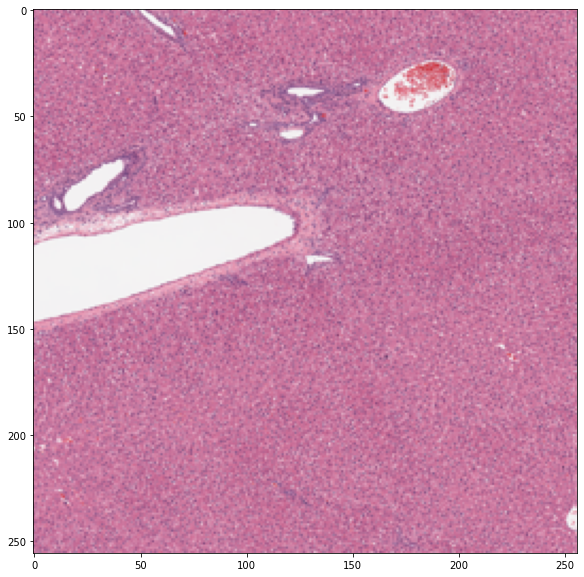

In [41]:
# 提取和可视化区域

# 定义提取区域的左上角坐标
topleft = (25000, 25000)
# 定义提取区域的大小
size = (256, 256)

# 对于每个级别进行迭代，共迭代4次
for l in range(4):
    # 更新提取区域的大小，每次乘以2
    size = (size[0] * 2, size[1] * 2)
    # 从幻灯片中读取指定区域
    region = slide.read_region(topleft, 0, size)
    # 调整提取的区域大小为 (256, 256)
    region = region.resize((256, 256))
    # 创建一个新的图形窗口，设置图形大小
    plt.figure(figsize=(10, 10))
    # 在图形窗口中显示提取的区域
    plt.imshow(region)


### Tissue segmentation

![](https://github.com/guillaumejaume/mil-tutorial/blob/main/support/segmentation.png?raw=true)

#### 组织分割的重要性：

- **去除非生物背景**：在组织病理学图像中，感兴趣的组织嵌入在背景中，这些背景经常包含伪影、染色、笔迹或其他非生物元素。这些元素没有任何有意义的生物信息，可能会干扰对组织结构的准确分析。通过分割和去除背景，计算病理学算法可以仅关注相关的组织区域，从而获得更精确和可靠的结果。

- **消除假相关性**：背景区域可能在下游分析中引入假相关性。如果背景未被正确去除，图像分析算法可能无意中将重要性分配给背景中存在的无关特征或模式。这可能导致错误的关联或误导性结果，影响计算病理学发现的准确性和可靠性。组织分割有助于通过仅分析生物学相关的成分来避免此类假相关性。

- **降低计算复杂性**：背景区域通常会增加图像分析算法的整体复杂性，而不提供任何有意义的信息。将这些区域包含在计算过程中会不必要地增加计算负担和分析所需的时间。通过分割和去除背景，可以显著降低计算复杂性，实现更高效和流畅的分析工作流程。这种优化在需要处理大量组织病理学图像的大规模研究或应用中尤为宝贵。

#### 组织分割的主要技术：

- **阈值法**：这是一种直接的技术，通过设置特定的强度阈值来区分组织和背景。强度值高于阈值的像素被归类为组织，低于阈值的则被视为背景。这种方法假定组织和背景之间有明显的对比，适用于边界清晰的图像。

- **基于区域的方法**：这些方法利用图像的颜色、纹理或强度变化等属性来识别组织区域。如区域生长、分水岭分割或图割等技术分析邻近像素的属性，迭代扩展或划分区域直到确定组织边界。当组织外观存在变化或组织与背景表现出不同特征时，基于区域的方法非常有用。

- **基于机器学习的方法**：随着机器学习的进步，可以使用监督学习或无监督学习等技术进行组织分割。监督学习涉及在一组标记的图像上训练模型，模型基于提供的注释学习区分组织和背景区域。无监督学习方法，如聚类或自动编码器，可以识别图像数据中的模式或簇，实现组织与背景的分离。

- **基于深度学习的方法**：深度学习方法，特别是卷积神经网络（CNN），在组织分割任务中显示出了显著的成功。这些模型可以直接从图像数据中学习层次化特征并进行像素级预测。完全卷积网络（FCN）、U-Net 或 Mask R-CNN 是常用的组

织分割架构。

#### 包含组织分割的现有库：

- CLAM（参见 https://github.com/mahmoodlab/CLAM）
- HistoCartography（参见 https://github.com/BiomedSciAI/histocartography）
- TIA ToolBox（参见 https://github.com/TissueImageAnalytics/tiatoolbox）

现有工具的概览可以在[这里](https://proceedings.mlr.press/v156/jaume21a/jaume21a.pdf)找到。

In [77]:
import numpy as np
import cv2

def segment_tissue(
    wsi,
    seg_level=2,
    sthresh=20,
    sthresh_up = 255,
    mthresh=7,
    close=0,
    use_otsu=False, 
    filter_params={'a_t':100, 'a_h': 4, 'max_n_holes': 5},
    ref_patch_size=512,
    exclude_ids=[],
    keep_ids=[]):
        """
            通过HSV -> 中值阈值 -> 二值化对组织进行分割
        """
        
        def _filter_contours(contours, hierarchy, filter_params):
            """
                根据面积过滤轮廓。
            """
            filtered = []

            # 找到前景轮廓的索引（parent == -1）
            hierarchy_1 = np.flatnonzero(hierarchy[:,1] == -1)
            all_holes = []
            
            # 遍历前景轮廓索引
            for cont_idx in hierarchy_1:
                # 实际轮廓
                cont = contours[cont_idx]
                # 此轮廓中包含的孔的索引（父轮廓的子轮廓）
                holes = np.flatnonzero(hierarchy[:, 1] == cont_idx)
                # 获取每个孔的轮廓面积
                hole_areas = [cv2.contourArea(contours[hole_idx]) for hole_idx in holes]
                # 实际前景轮廓区域的面积
                a = cv2.contourArea(cont)
                a = a - np.array(hole_areas).sum()
                if a == 0: continue
                if tuple((filter_params['a_t'],)) < tuple((a,)): 
                    filtered.append(cont_idx)
                    all_holes.append(holes)


            foreground_contours = [contours[cont_idx] for cont_idx in filtered]
            
            hole_contours = []

            for hole_ids in all_holes:
                unfiltered_holes = [contours[idx] for idx in hole_ids ]
                unfilered_holes = sorted(unfiltered_holes, key=cv2.contourArea, reverse=True)
                # 取最大的max_n_holes个孔
                unfilered_holes = unfilered_holes[:filter_params['max_n_holes']]
                filtered_holes = []
                
                # 过滤这些孔
                for hole in unfilered_holes:
                    if cv2.contourArea(hole) > filter_params['a_h']:
                        filtered_holes.append(hole)

                hole_contours.append(filtered_holes)

            return foreground_contours, hole_contours
        
        img = np.array(wsi.read_region((0,0), seg_level, wsi.level_dimensions[seg_level]))
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)     # 转换为HSV颜色空间
        img_med = cv2.medianBlur(img_hsv[:,:,1], mthresh)  # 应用中值模糊
                
        # 阈值化
        if use_otsu:
            _, img_otsu = cv2.threshold(img_med, 0, sthresh_up, cv2.THRESH_OTSU+cv2.THRESH_BINARY)
        else:
            _, img_otsu = cv2.threshold(img_med, sthresh, sthresh_up, cv2.THRESH_BINARY)

        # 形态学闭运算
        if close > 0:
            kernel = np.ones((close, close), np.uint8)
            img_otsu = cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, kernel)                 

        scale = int(wsi.level_dimensions[0][0] / wsi.level_dimensions[seg_level][0])
        scaled_ref_patch_area = int(ref_patch_size**2 / (scale * scale))
        filter_params = filter_params.copy()
        filter_params['a_t'] = filter_params['a_t'] * scaled_ref_patch_area
        filter_params['a_h'] = filter_params['a_h'] * scaled_ref_patch_area
        
        # 查找和过滤轮廓
        contours, hierarchy = cv2.findContours(img_otsu, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # 查找轮廓 
        hierarchy = np.squeeze(hierarchy, axis=(0,))[:, 2:]
        if filter_params:
            foreground_contours, hole_contours = _filter_contours(contours, hierarchy, filter_params)  # 过滤掉伪影

        contours_tissue = scale_contour_dim(foreground_contours, scale)
        holes_tissue = scale_holes_dim(hole_contours, scale)

        if len(keep_ids) > 0:
            contour_ids = set(keep_ids) - set(exclude_ids)
        else:
            contour_ids = set(np.arange(len(contours_tissue))) - set(exclude_ids)

        contours_tissue = [contours_tissue[i] for i in contour_ids]
        holes_tissue = [holes_tissue[i] for i in contour_ids]
        
        return contours_tissue, holes_tissue

def scale_contour_dim(contours, scale):
    return [np.array(cont * scale, dtype='int32') for cont in contours]

def scale_holes_dim(contours, scale):
    return [[np.array(hole * scale, dtype = 'int32') for hole in holes] for holes in contours]


# 调用segment_tissue函数进行组织分割
contours_tissue, holes_tissue = segment_tissue(slide)

# 打印检测到的轮廓数和孔数
print('检测到的轮廓数:', len(contours_tissue))
print('检测到的孔数:', sum([len(entry) for entry in holes_tissue]))

Number of contours detected: 2
Number of holes detected: 4


In [109]:
# 在缩略图上可视化分割质量

import math  # 导入用于数学操作的 math 库
from PIL import Image  # 从 PIL 库导入 Image 类

def vis_wsi(wsi,  # 可视化整张幻灯片图像（WSI）及其中的轮廓和孔
            contours_tissue,  # 表示组织区域的轮廓
            holes_tissue,  # 组织区域内的孔
            coords=None,  # 要突出显示的区域的坐标（可选）
            seg_level=2,  # 分割级别（默认为2）
            color=(0,255,0),  # 轮廓线的颜色（默认为绿色）
            hole_color=(0,0,255),  # 孔轮廓的颜色（默认为蓝色）
            line_thickness=250,  # 轮廓线的粗细（默认为250）
            custom_downsample=1,  # 图像调整大小的下采样因子（默认为1）
            number_contours=False,  # 是否为轮廓添加编号（默认为False）
    ):

    downsample = int(wsi.level_dimensions[0][0] / wsi.level_dimensions[seg_level][0])  # 计算下采样因子
    scale = [1/downsample, 1/downsample]  # 计算调整大小的比例
    top_left = (0,0)  # 定义要可视化的区域的左上角
    region_size = wsi.level_dimensions[seg_level]  # 获取要可视化的区域的大小

    img = np.array(wsi.read_region(top_left, seg_level, region_size).convert("RGB"))  # 读取幻灯片的区域并转换为RGB格式

    offset = tuple(-(np.array(top_left) * scale).astype(int))  # 计算轮廓绘制的偏移量
    line_thickness = int(line_thickness * math.sqrt(scale[0] * scale[1]))  # 根据比例调整线的粗细
    
    # 显示轮廓 
    if not number_contours:  # 如果不需要对轮廓编号
        cv2.drawContours(img, scale_contour_dim(contours_tissue, scale),  # 绘制按下采样因子缩放的轮廓
                         -1, color, line_thickness, lineType=cv2.LINE_8, offset=offset)
    else:  # 如果需要对轮廓编号
        for idx, cont in enumerate(contours_tissue):  # 遍历轮廓
            contour = np.array(scale_contour_dim(cont, scale))  # 缩放轮廓坐标
            M = cv2.moments(contour)  # 计算轮廓的矩
            cX = int(M["m10"] / (M["m00"] + 1e-9))  # 计算质心的x坐标
            cY = int(M["m01"] / (M["m00"] + 1e-9))  # 计算质心的y坐标
            # 绘制轮廓并在质心旁放置文本
            cv2.drawContours(img,  [contour], -1, color, line_thickness, lineType=cv2.LINE_8, offset=offset)
            cv2.putText(img, "{}".format(idx), (cX, cY),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 10)

    for holes in holes_tissue:
        cv2.drawContours(img, scale_contour_dim(holes, scale), 
                         -1, hole_color, line_thickness, lineType=cv2.LINE_8)
        
    if coords is not None:
        for coord in coords:
            downsample = 16 
            patch_size = int(256 / downsample)
            x1 = int(coord[0] / downsample)
            y1 = int(coord[1] / downsample)
            x2 = int(x1 + patch_size)
            y2 = int(y1 + patch_size)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,0), 2)

    img = Image.fromarray(img)

    w, h = img.size
    if custom_downsample > 1:
        img = img.resize((int(w/custom_downsample), int(h/custom_downsample)))

    return img


In [ ]:
img = vis_wsi(slide, contours_tissue, holes_tissue)
img.show()

### 幻灯片打补丁

根据组织分割的结果，我们现在将提取一系列固定（预定）大小的补丁。这些补丁将构成基于深度学习的任何下游应用的基础。

In [100]:
# 提取所有有效补丁的坐标

class IsInContour():
    def __init__(self, contour, patch_size, center_shift=0.5):
        self.cont = contour  # 轮廓
        self.patch_size = patch_size  # 补丁大小
        self.shift = int(patch_size//2*center_shift)  # 中心偏移量
        
    def __call__(self, pt): 
        center = (pt[0]+self.patch_size//2, pt[1]+self.patch_size//2)  # 补丁中心点坐标
        if self.shift > 0:
            all_points = [(center[0]-self.shift, center[1]-self.shift),
                          (center[0]+self.shift, center[1]+self.shift),
                          (center[0]+self.shift, center[1]-self.shift),
                          (center[0]-self.shift, center[1]+self.shift)
                          ]
        else:
            all_points = [center]

        for points in all_points:
            if cv2.pointPolygonTest(self.cont, tuple(np.array(points).astype(float)), False) >= 0:
                return 1  # 补丁中心位于轮廓内
        return 0  # 补丁中心位于轮廓外

def is_in_holes(holes, pt, patch_size):
    for hole in holes:
        if cv2.pointPolygonTest(hole, (pt[0]+patch_size/2, pt[1]+patch_size/2), False) > 0:
            return 1  # 补丁中心位于孔内
    return 0  # 补丁中心位于孔外


def is_in_contours(cont_check_fn, pt, holes=None, patch_size=256):
    if cont_check_fn(pt):  # 检查补丁中心是否位于轮廓内
        if holes is not None:
            return not is_in_holes(holes, pt, patch_size)  # 如果指定了孔，则检查补丁中心是否位于孔外
        else:
            return 1  # 如果未指定孔，则返回1，表示补丁中心位于轮廓内
    return 0  # 补丁中心位于轮廓外


def process_contours(wsi, contours_tissue, holes_tissue, patch_level=0, patch_size=256, step_size=256):
    n_contours = len(contours_tissue)  # 轮廓的数量
    print("Total number of contours to process: ", n_contours)
    fp_chunk_size = math.ceil(n_contours * 0.05)  # 迭代处理轮廓的阶段性进度输出的大小
    init = True
    all_coords = []  # 存储所有补丁的坐标
    for idx, cont in enumerate(contours_tissue):
        if (idx + 1) % fp_chunk_size == fp_chunk_size:
            print('Processing contour {}/{}'.format(idx, n_contours))  # 输出轮廓处理进度信息
        coords = process_contour(wsi, cont, holes_tissue[idx], patch_level, patch_size, step_size)  # 处理单个轮廓，获取补丁坐标
        all_coords.append(coords)  # 将补丁坐标添加到列表中
    flatten_coords = []
    for entry in all_coords:
        for coord in entry:
            flatten_coords.append(coord)
    return flatten_coords  # 返回所有补丁的坐标


def process_contour(
        wsi, 
        cont,
        contour_holes,
        patch_level,
        patch_size=256,
        step_size=256,
        use_padding=True,
    ):
    
    start_x, start_y, w, h = cv2.boundingRect(cont)  # 获取轮廓的边界框坐标和尺寸
    ref_patch_size = (patch_size, patch_size)  # 参考补丁的大小
    
    img_w, img_h = wsi.level_dimensions[0]  # 获取幻灯片图像的原始尺寸
    if use_padding:
        stop_y = start_y+h
        stop_x = start_x+w
    else:
        stop_y = min(start_y+h, img_h-ref_patch_size[1]+1)
        stop_x = min(start_x+w, img_w-ref_patch_size[0]+1)

    print("Bounding Box:", start_x, start_y, w, h)  # 输出轮廓的边界框信息
    print("Contour Area:", cv2.contourArea(cont))  # 输出轮廓的面积

    cont_check_fn = IsInContour(contour=cont, patch_size=ref_patch_size[0], center_shift=0.5)  # 创建用于检查补丁中心是否位于轮廓内的函数

    step_size_x = step_size 
    step_size_y = step_size 

    x_range = np.arange(start_x, stop_x, step=step_size_x)  # 计算沿x轴的坐标范围
    y_range = np.arange(start_y, stop_y, step=step_size_y)  # 计算沿y轴的坐标范围
    x_coords, y_coords = np.meshgrid(x_range, y_range, indexing='ij')  # 生成坐标网格
    coord_candidates = np.array([x_coords.flatten(), y_coords.flatten()]).transpose()  # 获取所有可能的补丁中心坐标

    results = []
    for coord in coord_candidates:
        if is_in_contours(cont_check_fn, coord, contour_holes, ref_patch_size[0]):  # 检查补丁中心是否位于轮廓内
            results.append(coord)  # 如果位于轮廓内，则将坐标添加到结果中
    results = np.array(results)
    print('Extracted {} coordinates'.format(len(results)))  # 输出提取的坐标数量
    return results  # 返回提取的坐标

coords = process_contours(slide, contours_tissue, holes_tissue)  # 提取所有有效补丁的坐标

Total number of contours to process:  2
Bounding Box: 4896 20160 50945 13953
Contour Area: 388059008.0
Extracted 5854 coordinates
Bounding Box: 320 3664 57105 23633
Contour Area: 573257856.0
Extracted 8910 coordinates


In [111]:
# visualize the patches 
img = vis_wsi(slide, contours_tissue, holes_tissue, coords)
img.show()